In [11]:
import numpy as np
from TMDP import TMDP
from River_swim import River

from algorithms import *
from model_functions import *

import matplotlib.pyplot as plt


#np.set_printoptions(precision=4)
import math
from utils import *

nS = 6
nA = 2
seed = 3231
gamma = .9
river = River(nS, gamma=gamma, small=5, large=1000, seed=seed)
tau = 0.4
xi = np.ones(nS) * 1/nS
tmdp = TMDP(river, xi, tau=tau, gamma=gamma, seed=seed)


In [6]:
r_s_a = compute_r_s_a(tmdp.P_mat_tau, tmdp.reward)
Q_star, _ = bellman_optimal_q(tmdp.P_mat_tau, tmdp.reward, gamma).values()
pi = get_policy(Q_star)
pi_prime = np.array([[0., 1.] for i in range(nS)])

V_star = get_value_function(Q_star)
print(tmdp.P_mat.shape)
print(Q_star)



(6, 2, 6)
[[275.85495966 271.98162658]
 [272.5216266  271.08632146]
 [270.72162678 273.66171778]
 [271.33727604 288.39015542]
 [279.29063239 349.46953126]
 [312.27349537 599.43448438]]


In [9]:
status_step = 10000

In [3]:
Q = np.zeros((nS, nA))
Qs = Q_learning(tmdp, Q, alpha=.5, episodes=100000, status_step=status_step)


In [4]:
print(Qs["Qs"][-1])
print(Qs["visits"])
print(len(Qs["Qs"]))


[[257.75725122 187.33611426]
 [262.44926324 173.72501519]
 [193.57206175 264.33305576]
 [183.1854361  274.74884827]
 [204.12791028 331.50574824]
 [271.0091271  543.76556504]]
107.43366963714092
[72746. 73144. 71196. 67958. 85348. 45938.]
11


In [39]:
tau_prime = 0.
metrics = compute_metrics(tmdp, Qs["Qs"], Q_star, tau_prime=tau_prime)
print(metrics)

{'J': [39.04658333333334, 253.42345101589223, 68.49315068493152, 68.49315068493146, 328.64251149906835, 328.64251149906835, 68.49315068493152, 12.820517123265386, 354.2185221916343, 409.0623884823195, 409.0623884823195, 409.0623884823195], 'J_tau': [11.77783923555556, 324.81963104246336, 225.6695836648105, 225.66958366481052, 330.43509986379706, 330.43509986379706, 225.66958366481026, 6.076615803725438, 340.76008933178394, 343.22208179026603, 343.22208179026603, 343.22208179026603], 'delta_J': [27.268744097777777, -71.39618002657113, -157.17643297987897, -157.17643297987905, -1.792588364728715, -1.792588364728715, -157.17643297987874, 6.743901319539948, 13.458432859850348, 65.84030669205345, 65.84030669205345, 65.84030669205345], 'delta_Q': [911.7079797434911, 510.0369104492722, 657.0317104907631, 378.63829947472556, 325.9915981812053, 123.54571769212797, 324.95801990162886, 315.2045975220559, 115.31126181805453, 111.83651819644422, 107.43366963714092, 0.0], 'l_bounds': [-19.3888581600

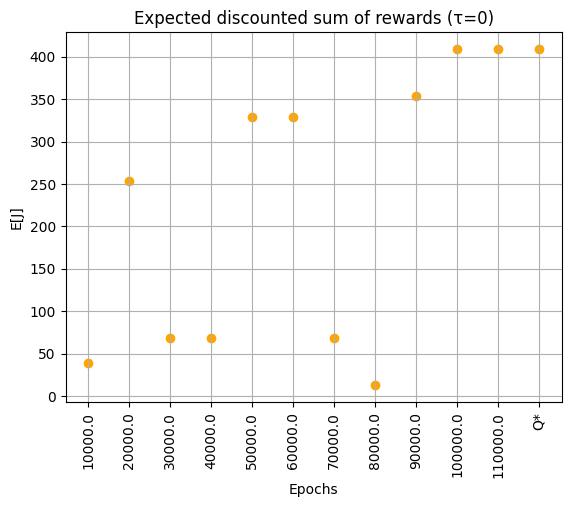

In [40]:
x = np.array([])
y = np.array([])
for i, J in enumerate(metrics["J"]):
    y = np.append(y, J)
    if i < len(metrics["J"])-1:
        x = np.append(x, (i+1)*status_step)
    else:
        x = np.append(x, "Q*")
x_map = np.array([i for i in range(len(x))])
plt.scatter(x, y, c="orange")
plt.xlabel("Epochs")
plt.xticks(rotation=90)
plt.ylabel("E[J]")
plt.title("Expected discounted sum of rewards (τ=0)")
plt.grid(visible=True)


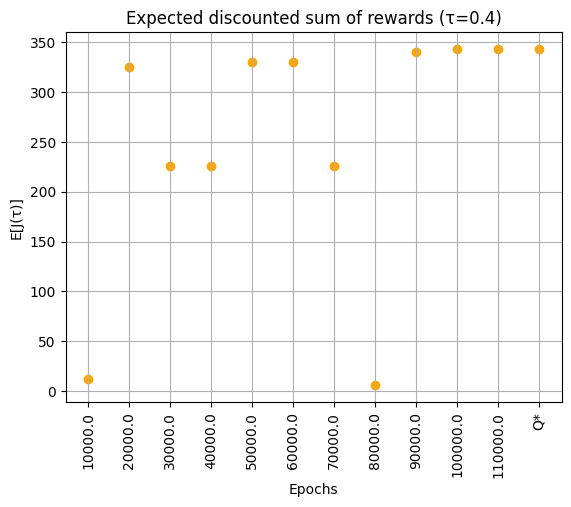

In [32]:
x = np.array([])
y = np.array([])
for i, J in enumerate(metrics["J_tau"]):
    y = np.append(y, J)
    if i < len(metrics["J_tau"])-1:
        x = np.append(x, (i+1)*status_step)
    else:
        x = np.append(x, "Q*")
x_map = np.array([i for i in range(len(x))])
plt.xticks(x_map, x)
plt.scatter(x, y, c="orange")
plt.xlabel("Epochs")
plt.xticks(rotation=90)
plt.ylabel("E[J(τ)]")
plt.title("Expected discounted sum of rewards (τ={})".format(tmdp.tau))
plt.grid(visible=True)

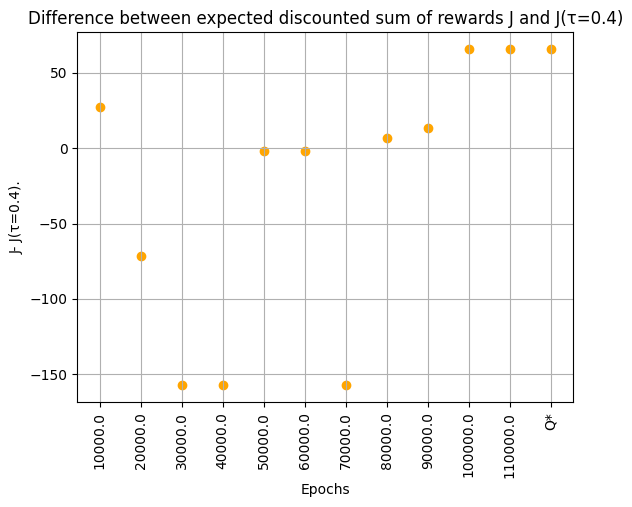

In [43]:
x = np.array([])
y = np.array([])
for i, J in enumerate(metrics["delta_J"]):
    y = np.append(y, J)
    if i < len(metrics["delta_J"])-1:
        x = np.append(x, (i+1)*status_step)
    else:
        x = np.append(x, "Q*")
x_map = np.array([i for i in range(len(x))])
plt.xticks(x_map, x)
plt.scatter(x, y, c="orange")
plt.xlabel("Epochs")
plt.xticks(rotation=90)
plt.ylabel("J- J(τ={}).".format(tmdp.tau))
plt.title("Difference between expected discounted sum of rewards J and J(τ={})".format(tmdp.tau))
plt.grid(visible=True)

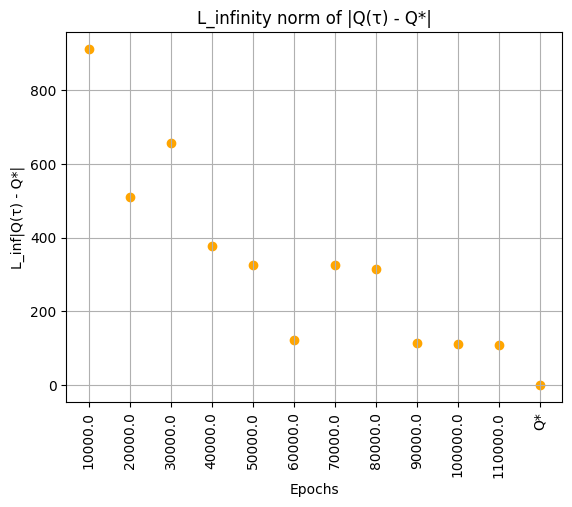

In [35]:
x = np.array([])
y = np.array([])
for i, J in enumerate(metrics["delta_Q"]):
    y = np.append(y, J)
    if i < len(metrics["delta_Q"])-1:
        x = np.append(x, (i+1)*status_step)
    else:
        x = np.append(x, "Q*")
x_map = np.array([i for i in range(len(x))])
plt.scatter(x, y, c="orange")
plt.xlabel("Epochs")
plt.xticks(rotation=90)
plt.ylabel("L_inf|Q(τ) - Q*|")
plt.title("L_infinity norm of |Q(τ) - Q*|")
plt.grid(visible=True)

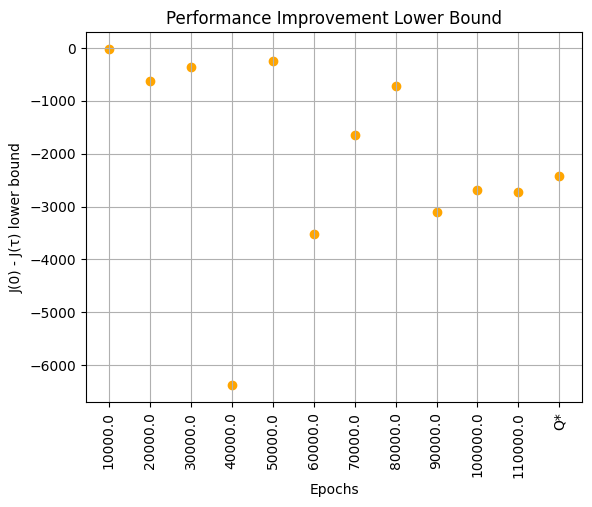

In [50]:
x = np.array([])
y = np.array([])
for i, J in enumerate(metrics["l_bounds"]):
    y = np.append(y, J)
    if i < len(metrics["l_bounds"])-1:
        x = np.append(x, (i+1)*status_step)
    else:
        x = np.append(x, "Q*")
x_map = np.array([i for i in range(len(x))])
plt.scatter(x, y, c="orange")
plt.xlabel("Epochs")
plt.xticks(rotation=90)
plt.ylabel("J(0) - J(τ) lower bound")
plt.title("Performance Improvement Lower Bound")
plt.grid(visible=True)

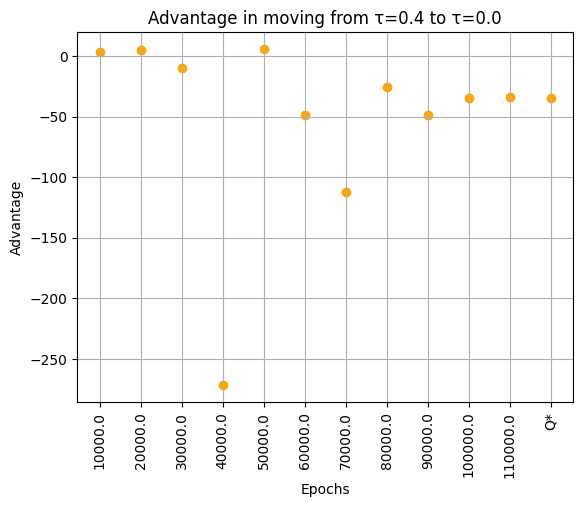

In [49]:
x = np.array([])
y = np.array([])
for i, J in enumerate(metrics["adv_terms"]):
    y = np.append(y, J)
    if i < len(metrics["adv_terms"])-1:
        x = np.append(x, (i+1)*status_step)
    else:
        x = np.append(x, "Q*")
x_map = np.array([i for i in range(len(x))])
plt.scatter(x, y, c="orange")
plt.xlabel("Epochs")
plt.xticks(rotation=90)
plt.ylabel("Advantage")
plt.title("Advantage in moving from τ={} to τ={}".format(tmdp.tau, tau_prime))
plt.grid(visible=True)

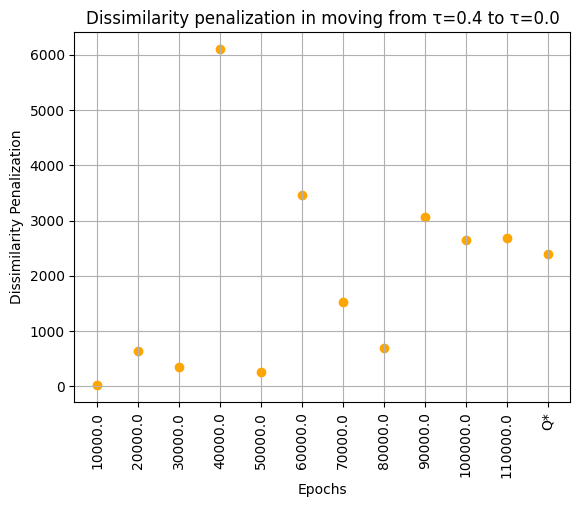

In [48]:
x = np.array([])
y = np.array([])
for i, J in enumerate(metrics["diss_terms"]):
    y = np.append(y, J)
    if i < len(metrics["diss_terms"])-1:
        x = np.append(x, (i+1)*status_step)
    else:
        x = np.append(x, "Q*")
x_map = np.array([i for i in range(len(x))])
plt.scatter(x, y, c="orange")
plt.xlabel("Epochs")
plt.xticks(rotation=90)
plt.ylabel("Dissimilarity Penalization")
plt.title("Dissimilarity penalization in moving from τ={} to τ={}".format(tmdp.tau, tau_prime))
plt.grid(visible=True)